In [1]:
import sklearn.metrics
import numpy as np
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

from IPython.display import display, Image

%matplotlib inline

# Стандартные метрики регрессии

- Общая концепция - $\frac1n \sum\limits_{i=1}^n L(a(x_i), y_i)$

-  MAE - Mean Absolute Error - $\frac1n \sum\limits_{i=1}^n |a(x_i) - y_i|$

- MSE - Mean Squared Error - $\frac1n \sum\limits_{i=1}^n (a(x_i) - y_i)^2$

- MAPE - Mean Absolute Percentage Error - $\frac1n \sum\limits_{i=1}^n \frac{|a(x_i) - y_i|}{y_i}$

- sMAPE - symmetric Mean Absolute Percentage Error - $\frac2n \sum\limits_{i=1}^n \frac{|a(x_i) - y_i|}{a(x_i) + y_i}$

Нарисуем функции потерь и попробуем догадаться, каким цветом они обозначены:

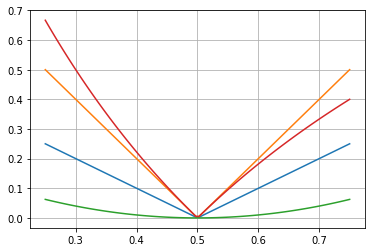

In [3]:
y_true = 0.5
y_pred = np.linspace(y_true * 0.5, y_true * 1.5, 100)

def create_regression_losses(y_true, y_pred, shuffle=True):

    loss1 = [np.abs(y_true - yp) for yp in y_pred]
    loss2 = [(y_true - yp) ** 2 for yp in y_pred]
    loss3 = [np.abs(y_true - yp) / y_true for yp in y_pred]
    loss4 = [2 * np.abs(y_true - yp) / (y_true + yp) for yp in y_pred]
    
    losses = [loss1, loss2, loss3, loss4]
    if shuffle:
        np.random.shuffle(losses)
    return losses

for loss in create_regression_losses(y_true, y_pred):
    plt.plot(y_pred, loss)

plt.grid()

In [42]:
data = load_diabetes()

In [43]:
cross_val_score(RandomForestRegressor(), data.data, data.target, cv=3, scoring='neg_mean_absolute_error')

array([-48.01891892, -46.70816327, -51.20204082])

In [44]:
cross_val_score(RandomForestRegressor(), data.data, data.target, cv=3, scoring='neg_mean_squared_error')

array([-3540.69581081, -3905.65489796, -3455.23027211])

In [45]:
cross_val_score(RandomForestRegressor(), data.data, data.target, cv=3, scoring='neg_mean_absolute_percentage_error')

ValueError: 'neg_mean_absolute_percentage_error' is not a valid scoring value. Valid options are ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']

In [46]:
def absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / y_true)

In [47]:
def symmetric_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / (y_true + y_pred))

In [48]:
cross_val_score(
    RandomForestRegressor(), 
    data.data, data.target, 
    cv=3, 
    scoring=sklearn.metrics.make_scorer(absolute_percentage_error, greater_is_better=False)
)

array([-0.41724882, -0.41746058, -0.40718118])

In [49]:
cross_val_score(
    RandomForestRegressor(random_state=42), 
    data.data, data.target, 
    cv=3,
    scoring=sklearn.metrics.make_scorer(symmetric_absolute_percentage_error, greater_is_better=False)
)

array([-0.16746928, -0.1772701 , -0.16144904])

In [50]:
def smape_scorer(estimator, X, y):
    pred = estimator.predict(X)
    return - symmetric_absolute_percentage_error(y, pred)

In [51]:
cross_val_score(
    RandomForestRegressor(random_state=42), 
    data.data, data.target, 
    cv=3, 
    scoring=smape_scorer
)

array([-0.16746928, -0.1772701 , -0.16144904])

In [52]:
cross_validate(
    RandomForestRegressor(random_state=42), 
    data.data, data.target, 
    cv=3, 
    scoring={
        'smape': smape_scorer,
        'mse': sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error, greater_is_better=False)
    },
    return_train_score=True
)

{'fit_time': array([0.01813507, 0.01718974, 0.017138  ]),
 'score_time': array([0.00158477, 0.00152922, 0.00142694]),
 'test_mse': array([-3303.04290541, -3733.33714286, -3448.65340136]),
 'test_smape': array([-0.16746928, -0.1772701 , -0.16144904]),
 'train_mse': array([-762.31615646, -702.55888136, -795.8660678 ]),
 'train_smape': array([-0.07686581, -0.07672183, -0.07875703])}

### Несколько свойств оптимизации метрик регрессии

- $\sum\limits_{i=1}^n \left(a(x_i) - y_i\right)^2 \to \min \implies a(x_i) \approx E(y \mid x = x_i)$

- $\sum\limits_{i=1}^n \left|~a(x_i) - y_i~\right| \to \min \implies a(x_i) \approx median(y \mid x = x_i)$

- $\sum\limits_{i=1}^n \alpha~(a(x_i) - y_i)~I\{a(x_i) \geq y_i\} + (1-\alpha)~(y_i - a(x_i))~I\{a(x_i) < y_i\} \to \min \implies a(x_i) \approx Z_{1 - \alpha}(y \mid x = x_i)$

**Докажите утверждения в случаях, если все $x_i$ одинаковые**

### Проверим пару из этих утверждений

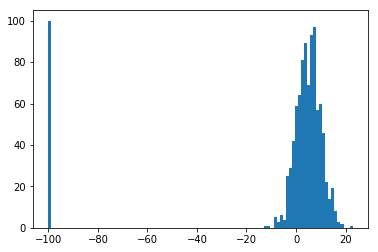

In [152]:
loc, scale = 5, 5
y_true = np.random.normal(loc, scale, 1000)
y_true[:100] = -100
plt.hist(y_true, bins=100);

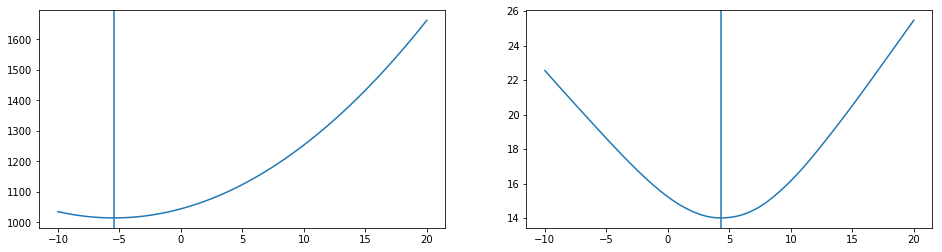

In [158]:
fig, axes = plt.subplots(1, 2, figsize=(16,4))

y_pred = np.linspace(loc - 3 * scale, loc + 3 * scale, 100)

loss = [np.mean((y_true - yp) ** 2) for yp in y_pred]
axes[0].plot(y_pred, loss)
axes[0].axvline(np.mean(y_true))

loss = [np.mean(np.abs(y_true - yp)) for yp in y_pred]
axes[1].plot(y_pred, loss)
axes[1].axvline(np.median(y_true))

### Как оптимизировать MAPE через оптимизацию MAE?

**Подберите такую функцию $f$, чтобы**

$\sum\limits_{i=1}^n \left|~f(a(x_i)) - f(y_i)~\right| \approx \sum\limits_{i=1}^n \frac{|a(x_i) - y_i|}{y_i}$

Возможно, стоит разложить левую часть в ряд Тейлора